# American Express - Default Prediction
Whether out at a restaurant or buying tickets to a concert, modern life counts on the convenience of a credit card to make daily purchases. It saves us from carrying large amounts of cash and also can advance a full purchase that can be paid over time. How do card issuers know we’ll pay back what we charge? That’s a complex problem with many existing solutions—and even more potential improvements, to be explored in this competition.
## Introduction
Credit default prediction is central to managing risk in a consumer lending business. Credit default prediction allows lenders to optimize lending decisions, which leads to a better customer experience and sound business economics. Current models exist to help manage risk. But it's possible to create better models that can outperform those currently in use.

In this competition, we’ll apply supervised machine learning to predict credit default. Specifically, we will leverage an industrial scale dataset to build binary classifaction models that challenge the current model in production. Training, validation, and testing datasets include: time-series, behavioral data, and anonymized customer profile information. Apart from creating a base model, we will explore numerous techniques and methodolgies to create an impressive model through feature engineering and using the data in a more organic way within a model.
### Objective
The objective of this competition is to predict the probability that a customer does not pay back their credit card balance amount in the future based on their monthly customer profile. The target binary variable is calculated by observing 18 months performance window after the latest credit card statement, and if the customer does not pay due amount in 120 days after their latest statement date it is considered a default event.
### Evaluation Criteria
If successful, our solution when implemented may yield better customer experiences for cardholders by making it easier for them to be approved for a new credit card. Top solutions may even challenge the credit default prediction model used by the world's largest payment card issuer at American Express.

## Data Preprocessing
### Project Setup and Configuration
#### Notebook Configuration

In [1]:
# Change working directory to project root
import os

if os.getcwd().split("/")[-1] == "notebooks":
    os.chdir("../")

#### Import Packages

In [2]:
# Import required packages
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

### Data Description
#### Files
| Filename | Description |
|-----------------|-----------------------|
|`train_data.csv`   | training data with multiple statement dates per `customer_ID`|
|`train_labels.csv` | target label for each `customer_ID`|
|`test_data.csv`    | corresponding test data; goal: predict `target label` for each `customer_ID`|
|`sample_submission.csv` | sample submission file in the correct format|
#### Feature/Target Variables
The dataset contains aggregated profile features for each customer at each statement date. 

Features are anonymized and normalized, and fall into the following general categories:
| Prefix | Feature Type |
|:------:|--------------|
|`D_*`| Delinquency |
|`S_*`| Spend |
|`P_*`| Payment |
|`B_*`| Balance |
|`R_*`| Risk |

with the following features being categorical: 
    `B_30`, `B_38`, `D_114`, `D_116`, `D_117`, `D_120`, `D_126`, `D_63`, `D_64`, `D_66`, `D_68`


**Objective:** For each `customer_ID`, predict the probability of a future payment default (`target == 1`).

**Note:** The negative class (`target == 0`) has been *subsampled at 5%*, and thus *receives a 20x weighting in the scoring metric*.

**Data Source (AMEX):**

American Express is a globally integrated payments company. As the largest payment card issuer in the world, they provide customers with access to products, insights, and experiences that enrich lives and build business success.

### Load AMEX Datasets
**Source (Raw Data):**
- https://www.kaggle.com/competitions/amex-default-prediction/data

**Source (Compressed Data):**
- https://www.kaggle.com/datasets/munumbutt/amexfeather

// TODO: Add information regarding the source, advantages and limitations in using the compressed datasets

In [3]:
#train = pd.read_csv("./data/raw/train_data.csv", low_memory=False)
#test = pd.read_csv("./data/raw/test_data.csv")

In [4]:
# Load compressed datasets
# Source: https://www.kaggle.com/datasets/munumbutt/amexfeather

train = pd.read_feather("./data/external/compressed/train_data.ftr")
#test = pd.read_feather("./data/external/compressed/test_data.ftr")

In [5]:
# Preview the first five rows of the training data
train.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938477,0.001734,0.008728,1.006836,0.009224,0.124023,0.008774,0.004707,...,NaN,NaN,0.002426,0.003706,0.003819,NaN,0.000569,0.000610,0.002674,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936523,0.005775,0.004925,1.000977,0.006153,0.126709,0.000798,0.002714,...,NaN,NaN,0.003956,0.003166,0.005032,NaN,0.009575,0.005493,0.009216,0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954102,0.091492,0.021652,1.009766,0.006817,0.123962,0.007599,0.009422,...,NaN,NaN,0.003269,0.007328,0.000427,NaN,0.003429,0.006985,0.002604,0
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960449,0.002455,0.013687,1.002930,0.001372,0.117188,0.000685,0.005531,...,NaN,NaN,0.006119,0.004517,0.003201,NaN,0.008423,0.006527,0.009598,0
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947266,0.002483,0.015190,1.000977,0.007607,0.117310,0.004654,0.009308,...,NaN,NaN,0.003672,0.004944,0.008888,NaN,0.001670,0.008125,0.009827,0


In [6]:
# Print the shape of the DataFrame for the training set
print(f"Training Data: Shape == {train.shape}")
print(f"\nThe training set consists of {train.shape[0]}\
    observations with {train.shape[1]} features\
    and 1 target variable.")

Training Data: Shape == (5531451, 191)

The training set consists of 5531451    observations with 191 features    and 1 target variable.


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5531451 entries, 0 to 5531450
Columns: 191 entries, customer_ID to target
dtypes: category(11), datetime64[ns](1), float16(177), int64(1), object(1)
memory usage: 2.0+ GB


In [8]:
# Preview the first five rows of the testing set
#test.head(5)

In [9]:
# Print the shape of the DataFrame for the testing dataset
'''
print(f"Testing Data: Shape == {test.shape}")
print(
    f"\nThe testing set consists of {test.shape[0]} observations with {test.shape[1]} features."
)
'''

'\nprint(f"Testing Data: Shape == {test.shape}")\nprint(\n    f"\nThe testing set consists of {test.shape[0]} observations with {test.shape[1]} features."\n)\n'

In [10]:
#test.info()

In [11]:
# 1-2) Sum the number of incomplete (missing or null) values in each column
# 3-4) Divide by the number of observations and multipy by 100 to make it a percentage.
#   5) Lastly, sort the values in descending order to better observe feature incompleteness.
pct_incomplete = (
    train.isna().sum().div(len(train)).mul(100).sort_values(ascending=False)
)

# Subset pct_incomplete to select incomplete features (Threshold: >20%)
incomplete_features = set(pct_incomplete[pct_incomplete >= 20].index)

In [12]:
# Print the count of incomplete features
print(
    f"{len(incomplete_features)} features with over 20% values are missing or null.\n"
)

# Print column names of features where 20% or greater have missing or null values
print(f"Incomplete Features: \n{incomplete_features}")

34 features with over 20% values are missing or null.

Incomplete Features: 
{'D_46', 'D_105', 'R_9', 'D_134', 'D_49', 'B_39', 'D_136', 'D_138', 'D_73', 'D_110', 'D_77', 'D_82', 'S_27', 'D_132', 'D_42', 'D_137', 'D_50', 'D_135', 'B_29', 'D_142', 'S_9', 'D_108', 'D_66', 'D_87', 'B_42', 'D_88', 'D_111', 'D_76', 'D_53', 'D_43', 'D_56', 'D_106', 'R_26', 'B_17'}


In [13]:
statement_counts = (train
                    .groupby('customer_ID')
                    .size()
                    .value_counts(normalize=True)
                    .sort_index()
                    .reset_index()
                    .rename(columns={
                        'index':'n_statements', 0: 'pct_customers'}
                    ))

In [14]:
statement_counts

,n_statements,pct_customers
0,1,0.011157
1,2,0.013288
2,3,0.012591
3,4,0.010183
4,5,0.010178
5,6,0.012018
6,7,0.011327
7,8,0.013314
8,9,0.013970
9,10,0.014645


<AxesSubplot:xlabel='n_statements', ylabel='pct_customers'>

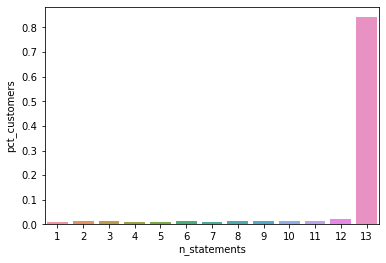

In [15]:
sns.barplot(data=statement_counts, x='n_statements', y='pct_customers')

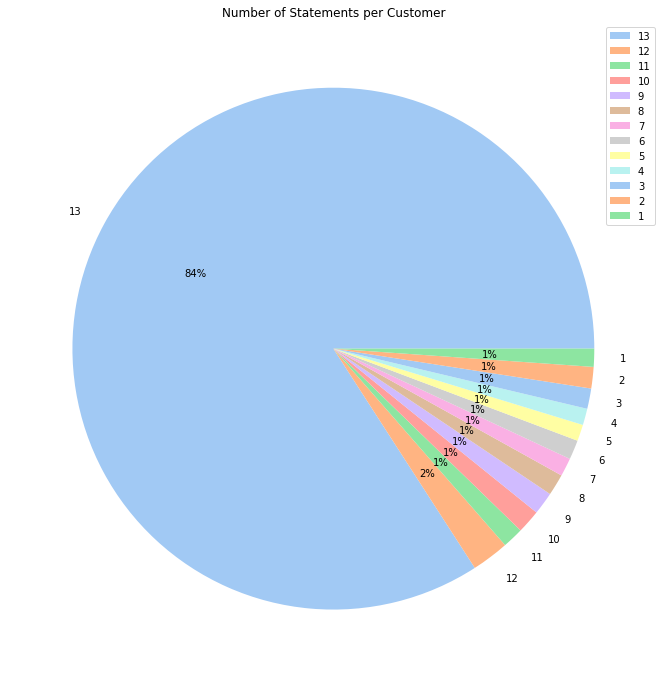

In [16]:
colors = sns.color_palette('pastel')
fig = plt.figure(figsize = (12, 12))
plt.pie(x=statement_counts['pct_customers'][::-1], 
        labels=statement_counts['n_statements'][::-1],
        colors = colors, 
        autopct = '%0.0f%%')
plt.title('Number of Statements per Customer')
plt.legend(loc='upper right')
plt.show()

In [17]:

# def amex_vars(data=train, select=None, include_target=False, y_col='target'):

In [18]:
def amex_filter(data, feature_type='all', target=False):
    features_dict = {
        'deliquency': data.columns[data.columns.str.startswith('D_')],
        'balance': data.columns[data.columns.str.startswith('B_')],
        'spend': data.columns[data.columns.str.startswith('S_')],
        'risk': data.columns[data.columns.str.startswith('R_')],
        'payment': data.columns[data.columns.str.startswith('P_')],
        'numeric': data.select_dtypes(include='number').columns,
        'categorical': data.select_dtypes(include='category').columns,
        'all': data.columns}
   
    if not isinstance(feature_type, str):
        raise TypeError(
            f'Invalid input - expected str, but acutal: {type(feature_type)}')
    elif feature_type not in features_dict.keys():
        raise ValueError('Invalid feature selection')
    elif target and 'target' not in data.columns:
        raise ValueError("Target is not present in dataset!")
    
    f_columns = list(features_dict.get(feature_type))
    if target and 'target' not in f_columns: 
        f_columns.append('target')
    elif 'target' in f_columns:
        f_columns.remove('target')
    
    return data.loc[:, f_columns]

In [19]:
amex_filter(train, feature_type='categorical')

,D_63,D_64,D_66,D_68,B_30,B_38,D_114,D_116,D_117,D_120,D_126
0,CR,O,NaN,6.0,0.0,2.0,1.0,0.0,4.0,0.0,1.0
1,CR,O,NaN,6.0,0.0,2.0,1.0,0.0,4.0,0.0,1.0
2,CR,O,NaN,6.0,0.0,2.0,1.0,0.0,4.0,0.0,1.0
3,CR,O,NaN,6.0,0.0,2.0,1.0,0.0,4.0,0.0,1.0
4,CR,O,NaN,6.0,0.0,2.0,1.0,0.0,4.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
5531446,CL,O,NaN,5.0,0.0,3.0,1.0,0.0,3.0,0.0,1.0
5531447,CL,O,NaN,5.0,0.0,3.0,1.0,0.0,3.0,0.0,1.0
5531448,CL,O,NaN,5.0,0.0,3.0,1.0,0.0,3.0,0.0,1.0
5531449,CL,O,NaN,5.0,0.0,3.0,1.0,0.0,3.0,0.0,1.0


df_deliquency = train.iloc[:, train.columns.str.startswith('D_')]
df_balance = train.iloc[:, train.columns.str.startswith('B_')]
df_spend = train.iloc[:, train.columns.str.startswith('S_')]
df_risk = train.iloc[:, train.columns.str.startswith('R_')]
df_payment = train.iloc[:, train.columns.str.startswith('P_')]

In [20]:
(train
.pipe(amex_filter, feature_type='deliquency')
.pipe(amex_filter, feature_type='categorical')
.describe())

,D_63,D_64,D_66,D_68,D_114,D_116,D_117,D_120,D_126
count,5531451,5531451,623354.0,5314948.0,5354735.0,5354735.0,5354735.0,5354735.0,5414635.0
unique,6,5,2.0,7.0,2.0,2.0,7.0,2.0,3.0
top,CO,O,1.0,6.0,1.0,0.0,-1.0,0.0,1.0
freq,4119621,2913244,617066.0,2782455.0,3316478.0,5348109.0,1456084.0,4729723.0,4262414.0


In [21]:
(train
.pipe(amex_filter, feature_type='deliquency')
.pipe(amex_filter, feature_type='numeric')
.describe())

,D_39,D_41,D_42,D_43,D_44,D_45,D_46,D_47,D_48,D_49,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
count,5.531451e+06,5.529435e+06,791314.000000,3.873055e+06,5.257132e+06,5.529434e+06,4.319752e+06,5.531451e+06,4.812726e+06,5.455340e+05,...,1.946990e+05,194699.000000,1.946990e+05,5.429903e+06,5.490819e+06,5.429903e+06,944408.000000,5.429903e+06,5.490724e+06,5.429903e+06
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000e+00,0.000000,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
min,0.000000e+00,0.000000e+00,-0.000454,1.192093e-07,0.000000e+00,0.000000e+00,-1.729688e+01,-2.662659e-02,-9.613037e-03,4.768372e-07,...,5.960464e-08,0.000000,5.960464e-08,0.000000e+00,0.000000e+00,0.000000e+00,-0.014542,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.528046e-03,2.872467e-03,0.037506,4.226685e-02,3.833771e-03,5.462646e-02,4.250488e-01,2.322998e-01,8.099365e-02,6.158447e-02,...,9.315491e-03,0.002533,3.517151e-03,3.026962e-03,2.555847e-03,3.026962e-03,0.199341,3.028870e-03,2.752304e-03,3.028870e-03
50%,9.056091e-03,5.744934e-03,0.120544,8.850098e-02,7.667542e-03,1.807861e-01,4.597168e-01,3.830566e-01,2.861328e-01,1.303711e-01,...,2.539062e-01,0.005070,7.038116e-03,6.053925e-03,5.111694e-03,6.050110e-03,0.382080,6.053925e-03,5.508423e-03,6.053925e-03
75%,2.366943e-01,8.613586e-03,0.250977,1.843262e-01,1.319580e-01,3.732910e-01,5.175781e-01,5.615234e-01,6.694336e-01,2.467041e-01,...,2.583008e-01,0.007572,5.014648e-01,9.078979e-03,7.663727e-03,9.078979e-03,0.559082,9.078979e-03,8.262634e-03,9.078979e-03
max,5.390625e+00,8.992188e+00,4.191406,1.010938e+01,5.632812e+00,1.610352e+00,1.631250e+01,1.643555e+00,8.968750e+00,4.584375e+01,...,1.759766e+00,1.009766,3.005859e+00,1.009766e+00,1.009766e+00,1.339844e+00,2.228516,1.009766e+00,1.343750e+00,4.828125e+00


In [22]:
(train
.pipe(amex_filter, feature_type='balance')
.pipe(amex_filter, feature_type='categorical')
.describe())

,B_30,B_38
count,5529435.0,5529435.0
unique,3.0,7.0
top,0.0,2.0
freq,4710663.0,1953232.0


In [23]:
(train
.pipe(amex_filter, feature_type='balance')
.pipe(amex_filter, feature_type='numeric')
.describe())

,B_1,B_2,B_3,B_4,B_5,B_6,B_7,B_8,B_9,B_10,...,B_29,B_31,B_32,B_33,B_36,B_37,B_39,B_40,B_41,B_42
count,5.531451e+06,5.529435e+06,5.529435e+06,5.531451e+06,5.531451e+06,5.531218e+06,5.531451e+06,5.509183e+06,5.531451e+06,5.531451e+06,...,381416.000000,5531451.0,5.531451e+06,5.529435e+06,5.531451e+06,5.531395e+06,33632.000000,5.531398e+06,5.530761e+06,71478.000000
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000e+00,NaN,0.254395,NaN,NaN,0.000000
std,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00,0.000000e+00,NaN,...,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.297852,NaN,0.000000e+00,0.000000
min,-7.589844e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-5.176544e-03,-2.652344e+00,0.000000e+00,0.000000e+00,-2.958298e-03,...,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,-7.605469e+00,-0.979492,0.000000e+00,0.000000e+00,0.000003
25%,8.865356e-03,1.053467e-01,5.226135e-03,2.749634e-02,7.282257e-03,2.049255e-02,2.824402e-02,4.505157e-03,5.752563e-03,2.899170e-02,...,0.002558,1.0,2.555847e-03,6.362915e-03,2.513885e-03,8.834839e-03,0.058380,1.739502e-02,2.553940e-03,0.007259
50%,3.134155e-02,8.144531e-01,9.780884e-03,8.221436e-02,1.537323e-02,8.337402e-02,7.574463e-02,9.017944e-03,2.587891e-02,1.105347e-01,...,0.005089,1.0,5.115509e-03,1.001953e+00,5.027771e-03,3.114319e-02,0.149170,5.831909e-02,5.107880e-03,0.021606
75%,1.258545e-01,1.001953e+00,1.550293e-01,2.388916e-01,5.371094e-02,1.918945e-01,2.709961e-01,1.003906e+00,3.342285e-01,2.956543e-01,...,0.007633,1.0,7.675171e-03,1.005859e+00,7.541656e-03,1.238403e-01,0.291504,2.451172e-01,7.659912e-03,0.105591
max,1.324219e+00,1.009766e+00,1.625000e+00,1.979688e+01,1.442500e+02,1.215000e+03,1.252930e+00,1.019531e+00,2.742188e+01,4.096000e+03,...,12.023438,1.0,1.009766e+00,1.009766e+00,1.001953e+00,1.328125e+00,2.060547,5.756000e+03,2.200000e+01,9.054688


In [24]:
df_spend = amex_filter(train, feature_type='spend')
df_spend.describe()

,S_3,S_5,S_6,S_7,S_8,S_9,S_11,S_12,S_13,S_15,...,S_17,S_18,S_19,S_20,S_22,S_23,S_24,S_25,S_26,S_27
count,4.510907e+06,5.531451e+06,5.531451e+06,4.510907e+06,5.531451e+06,2.597808e+06,5.531451e+06,5.531451e+06,5.531451e+06,5.531451e+06,...,5.531451e+06,5.531451e+06,5.531451e+06,5.531451e+06,5.512427e+06,5.531006e+06,5.512858e+06,5.518604e+06,5.530817e+06,4.130516e+06
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
min,-6.269531e-01,0.000000e+00,0.000000e+00,-4.702148e-01,0.000000e+00,2.980232e-07,-1.999512e-01,-4.040527e-01,0.000000e+00,-3.000488e-01,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-9.200000e+01,-2.061250e+02,-9.050000e+01,-2.453125e+00,0.000000e+00,0.000000e+00
25%,1.273193e-01,5.634308e-03,3.284454e-03,9.375000e-02,7.644653e-03,9.788513e-03,2.824707e-01,1.868896e-01,4.894257e-03,2.075195e-01,...,2.685547e-03,2.571106e-03,2.504349e-03,2.532959e-03,8.110352e-01,1.334229e-01,8.095703e-01,9.707031e-01,3.414154e-03,6.362915e-03
50%,1.639404e-01,1.351929e-02,6.572723e-03,1.396484e-01,3.217773e-01,1.950073e-02,2.897949e-01,1.907959e-01,9.796143e-03,4.018555e-01,...,5.367279e-03,5.134583e-03,5.008698e-03,5.062103e-03,9.423828e-01,1.362305e-01,9.492188e-01,9.736328e-01,6.755829e-03,2.905273e-01
75%,2.580566e-01,7.135010e-02,9.857178e-03,2.954102e-01,4.948730e-01,5.322266e-02,4.487305e-01,2.088623e-01,4.277344e-01,5.048828e-01,...,8.049011e-03,7.701874e-03,7.511139e-03,7.591248e-03,9.648438e-01,1.390381e-01,9.716797e-01,9.765625e-01,1.103210e-02,4.477539e-01
max,5.484375e+00,2.068750e+02,1.009766e+00,3.949219e+00,1.231445e+00,2.839844e+00,3.800781e+00,1.753750e+02,1.009766e+00,5.308594e+00,...,4.050781e+00,1.009766e+00,1.004883e+00,1.009766e+00,1.033203e+00,8.855000e+02,1.055664e+00,4.050781e+00,1.366250e+02,5.457031e+00


In [25]:
df_risk = amex_filter(train, feature_type='risk')
df_risk.describe()

,R_1,R_2,R_3,R_4,R_5,R_6,R_7,R_8,R_9,R_10,...,R_19,R_20,R_21,R_22,R_23,R_24,R_25,R_26,R_27,R_28
count,5.531451e+06,5.531451e+06,5.531451e+06,5.531451e+06,5.531451e+06,5.531451e+06,5.531450e+06,5.531451e+06,3.125330e+05,5.531451e+06,...,5.531451e+06,5.531376e+06,5.531451e+06,5.531451e+06,5.531451e+06,5.531451e+06,5.531451e+06,609305.000000,5.402748e+06,5.531451e+06
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000,NaN,0.000000e+00
std,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.980232e-07,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,-2.571106e-02,0.000000e+00
25%,2.895355e-03,2.613068e-03,4.699707e-03,2.565384e-03,2.574921e-03,2.592087e-03,2.569199e-03,2.553940e-03,1.690674e-01,2.624512e-03,...,2.548218e-03,2.536774e-03,2.536774e-03,2.506256e-03,2.502441e-03,2.534866e-03,2.510071e-03,0.005245,1.001953e+00,2.502441e-03
50%,5.783081e-03,5.222321e-03,9.399414e-03,5.130768e-03,5.149841e-03,5.187988e-03,5.134583e-03,5.104065e-03,1.727295e-01,5.249023e-03,...,5.092621e-03,5.077362e-03,5.081177e-03,5.016327e-03,5.001068e-03,5.069733e-03,5.016327e-03,0.036865,1.003906e+00,5.004883e-03
75%,8.659363e-03,7.835388e-03,2.003174e-01,7.701874e-03,7.720947e-03,7.781982e-03,7.701874e-03,7.656097e-03,1.763916e-01,7.865906e-03,...,7.633209e-03,7.614136e-03,7.625580e-03,7.526398e-03,7.499695e-03,7.602692e-03,7.526398e-03,0.077148,1.006836e+00,7.507324e-03
max,3.255859e+00,1.009766e+00,1.160156e+01,1.009766e+00,3.500000e+01,1.444531e+01,4.500000e+02,3.800000e+01,1.509766e+00,2.100000e+01,...,1.009766e+00,4.500000e+01,1.009766e+00,1.009766e+00,1.009766e+00,1.009766e+00,1.009766e+00,9.507812,1.009766e+00,1.009766e+00


In [26]:
df_payment = amex_filter(train, feature_type='payment')
df_payment.describe()

,P_2,P_3,P_4
count,5.485466e+06,5.229959e+06,5.531451e+06
mean,NaN,NaN,NaN
std,0.000000e+00,0.000000e+00,0.000000e+00
min,-4.589844e-01,-1.519531e+00,0.000000e+00
25%,4.802246e-01,5.410156e-01,2.923965e-03
50%,6.943359e-01,6.181641e-01,5.847931e-03
75%,8.647461e-01,6.835938e-01,8.766174e-03
max,1.009766e+00,2.427734e+00,1.269531e+00


In [27]:
train.target.astype('category').describe()

count     5531451
unique          2
top             0
freq      4153582
Name: target, dtype: int64

In [28]:
train.target.value_counts(normalize=True)

0    0.750903
1    0.249097
Name: target, dtype: float64

In [29]:
# last_statement = train.groupby('customer_ID').tail(1).set_index('customer_ID')
# last_statement.target.value_counts(normalize=True)

In [31]:
y_amex = train.set_index('customer_ID').groupby('customer_ID').tail(1).target
X_amex = train.set_index('customer_ID').drop(['S_2', 'target'], axis=1)

In [39]:
def aggregate_features(X_amex):
    numeric__agg = (X_amex
                    .select_dtypes(include='number')
                    .groupby('customer_ID')
                    .agg(['first', 'last', 'mean', 'min', 'max', 'std']))
    
    categorical__agg = (X_amex
                    .select_dtypes(include='category')
                    .groupby('customer_ID')
                    .agg(['first', 'last', 'count', 'nunique']))

    X_amex__agg = pd.concat([categorical__agg, numeric__agg], axis=1)
    X_amex__agg.columns = ['__'.join(col) for col in X_amex__agg.columns]

    return X_amex__agg

In [ ]:
X_amex__agg = aggregate_features(X_amex)

: 

In [40]:
from sklearn.model_selection import train_test_split


ModuleNotFoundError: No module named 'sklearn'

amex_numeric__agg = (X_amex
                     .select_dtypes(include='number')
                     .groupby('customer_ID')
                     .agg(['first', 'last', 'mean', 'min', 'max', 'std']))

# amex_numeric__agg.columns = ['__'.join(c) for c in amex_numeric__agg.columns]
amex_numeric__agg.head(2)

amex_categorical__agg = (X_amex
                         .select_dtypes(include='category')
                         .groupby('customer_ID')
                         .agg(['first', 'last', 'count', 'nunique']))

# amex_categorical__agg.columns = [
    #'__'.join(c) for c in amex_categorical__agg.columns]
amex_categorical__agg.head(2)

X_agg = pd.concat([amex_categorical__agg, amex_numeric__agg], axis=1)
X_agg.columns = ['__'.join(col) for col in X_agg.columns]
X_agg.head(1)

In [35]:
# (X_agg.index == amex_y.index).all()

True